# TTN CLASSIFIER

In this notebook we will shown an example of how to use our packages in order to create a TTN classifier.The packages we present are included in the utils and layers folders.

In [1]:
#import python libries 
import os
import json

import pandas            as pd
import tensorflow        as tf
import tensornetwork     as tn
import numpy             as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score

In [2]:
#import TTN package and preprocess package
import utils.preprocess  as preprocess                  #dataset preprocessing
 
from layers.TTN_SingleNode import TTN_SingleNode        #single node layer
from ModelMaker            import Make_SingleNode_Model #model builder

## LOAD AND PREPROCESS THE DATASET

Given the path were data is present and the number of sample to load we retrieve them using a pandas dataframe. The dataset is then proprocessed depending on the required map, map order and number of features to contract to each weight tensor.

In [3]:
#dataset path
DATA_PATH = "../data/"
N = 1100000 #number of sample to load

#dataset loading
if os.path.isfile(DATA_PATH + "HIGGS.csv.gz"):
    data = pd.read_csv(
                DATA_PATH         + 'HIGGS.csv.gz'       ,  
                compression='gzip', error_bad_lines=False, 
                nrows=N           , header=None          
            )
elif os.path.isfile(DATA_PATH + "HIGGS.csv"):
    data = pd.read_csv(
                DATA_PATH + 'HIGGS.csv',    nrows=N  ,
                error_bad_lines=False  , header=None 
            )
else:
    print("Error: Data file not found")

In [4]:
#dataset preprocessing
x_train, x_val, x_test, y_train, y_val, y_test = \
    preprocess.Preprocess(
        data                       , 
        feature_map  = 'spherical' , #map typology
        map_order    = 2           , #map order
        con_order    = 2           , #number of contraction per site
        verbose      = True        , #verbose (print shapes for debugging)
        N_train      = 1000000     , #train set size
        N_val        = 50000       , #validation set size
        N_test       = 50000         #test set size
    )

Data shape
x_data shape:  (1100000, 28) y_data shape:  (1100000,)
Padded data shape
x_data shape:  (1100000, 32) y_data shape:  (1100000,)
Mapped data shape
x_data shape:  (1100000, 32, 2) y_data shape:  (1100000,)
Train, validation, test data shape
x_train shape:  (1000000, 32, 2) y_train shape:  (1000000,)
x_val   shape:  (50000, 32, 2) y_val   shape:  (50000,)
x_test  shape:  (50000, 32, 2) y_test  shape:  (50000,)


## MODEL CREATION

Create a TTN model using the apposite function. From the input shape of the dataset the function will initialze a correct umber of layer to obtain a final prediction for the sample classes

In [5]:
#instantiate the model, two models are provided, a comparison between them is whoen in the Characterization notebook

#this model is a "pure" ttn with no optimizations nor activations
tn_model = Make_SingleNode_Model( input_shape=(x_train.shape[1:]),bond_dim=15, activation=None, use_batch_norm=False,use_reg =False, n_contr=2)
#this model uses elu activation function kernel regualrization and batch normalization
#uncomment this line to use the optimized mode 
#tn_model = Make_SingleNode_Model( input_shape=(x_train.shape[1:]),bond_dim=10, activation=None, use_batch_norm=False,use_reg =False, n_contr=2

#compile the model



tn_model.compile(
    optimizer = 'adam',                #optimizer
    loss      = 'binary_crossentropy', #loss function
    metrics   = ['accuracy']           # metric to observe
)
tn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ttn__single_node (TTN_Single (None, 16, 15)            1200      
_________________________________________________________________
ttn__single_node_1 (TTN_Sing (None, 8, 15)             27120     
_________________________________________________________________
ttn__single_node_2 (TTN_Sing (None, 4, 15)             13560     
_________________________________________________________________
ttn__single_node_3 (TTN_Sing (None, 2, 15)             6780      
_________________________________________________________________
ttn__single_node_4 (TTN_Sing (None, 1, 1)              226       
Total params: 48,886
Trainable params: 48,886
Non-trainable params: 0
_________________________________________________________________


## TRAINING

Training is executed over the training set. During the training procedure, using a custom callback, we can obtain the training time needed for each epoch.

In [6]:
#custom callback for epoch training time
class timecallback(tf.keras.callbacks.History):
    def __init__(self):
        self.times = []
        self.epochs = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tf.timestamp()
    def on_epoch_end(self,epoch,logs = {}):
        time_epoch = tf.timestamp()
        self.times.append(time_epoch - self.timetaken)
        self.timetaken = time_epoch
        self.epochs.append(epoch)
    def on_train_end(self,logs = {}):
        self.times = [t.numpy() for t in self.times]
        
timeCall = timecallback()

In [7]:
# Train the tensorized model for n epochs
#with tf.device('/device:cpu:0'): #change to cpu is gpu is not avaible
with tf.device('/device:gpu:0'):
    history = tn_model.fit(
        x_train, y_train,
        validation_data = (x_val,y_val), #validation set
        epochs          = 15           , #trianing epochs           
        batch_size      = 5000         ,
        callbacks       = [timeCall]
    )
    

Train on 1000000 samples, validate on 50000 samples
Epoch 1/15
1000000/1000000 [==============================] - 10s 10us/sample - loss: 0.6830 - accuracy: 0.5620 - val_loss: 0.6737 - val_accuracy: 0.5964
Epoch 2/15
1000000/1000000 [==============================] - 6s 6us/sample - loss: 0.6637 - accuracy: 0.6025 - val_loss: 0.6513 - val_accuracy: 0.6235
Epoch 3/15
1000000/1000000 [==============================] - 6s 6us/sample - loss: 0.6408 - accuracy: 0.6386 - val_loss: 0.6341 - val_accuracy: 0.6455
Epoch 4/15
1000000/1000000 [==============================] - 6s 6us/sample - loss: 0.6316 - accuracy: 0.6495 - val_loss: 0.6246 - val_accuracy: 0.6583
Epoch 5/15
1000000/1000000 [==============================] - 6s 6us/sample - loss: 0.6245 - accuracy: 0.6591 - val_loss: 0.6230 - val_accuracy: 0.6638
Epoch 6/15
1000000/1000000 [==============================] - 6s 6us/sample - loss: 0.6203 - accuracy: 0.6628 - val_loss: 0.6181 - val_accuracy: 0.6675
Epoch 7/15
1000000/1000000 [======

## SMALL ANALYSIS OF THE MODEL

Here some simple analysis that can be done after the training procedure. 

In [8]:
print("Mean training time      :", round(np.mean(np.array(timeCall.times))   , 3))
print("Max accuraty            :", round(max(history.history['accuracy'])    , 3))
print("Max validation accuraty :", round(max(history.history['val_accuracy']), 3))

Mean training time      : 6.164
Max accuraty            : 0.684
Max validation accuraty : 0.682


In [9]:
#evaluation of the model on a test set
res = tn_model.evaluate(x_test, y_test)
print("Model test accuracy: ", res[1])

50000/50000 [==============================] - 8s 163us/sample - loss: 0.5984 - accuracy: 0.6841
Model test accuracy:  0.68412


No Skill : ROC AUC=0.500
TTN model: ROC AUC=0.745


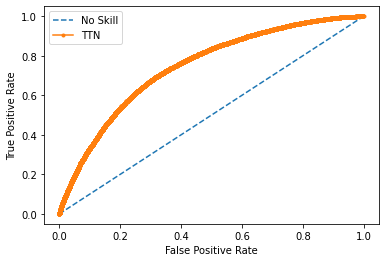

In [10]:
#compute ROC curve and AUC score
y_pred = tn_model.predict(x_test).flatten()

ns_probs = [0 for _ in range(len(y_test))] #always zero model
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_pred)
# summarize scores
print('No Skill : ROC AUC=%.3f' % (ns_auc))
print('TTN model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.',     label='TTN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
